In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from time import time

# Yüz Tanıma (Face Recognition)

Bu challenge’da:

* PCA kullanarak **ünlü kişilerin siyah-beyaz (B&W) görüntülerini sıkıştıracağız**
* Sıkıştırılmış görüntüleri bir sınıflandırma görevi için örnekler olarak kullanacağız

Bu kez, önceki K-means challenge’ının aksine:

Tek bir görüntü üzerinde, **pikseller arasındaki** desenleri bulup renk sayısını azaltmak için denetimsiz öğrenme yapmak yerine, **birden fazla B&W görüntüden oluşan bir veri seti** üzerinde çalışacağız ve şunları hedefleyeceğiz:

- **Tüm görüntüler arasındaki** ortak desenleri bulmak
- Bu görüntüleri tanımlayan **“temel (principal) feature” sayısını azaltmak**

Daha açık bir ifadeyle, veri setimizdeki her bir görüntüyü PCA kullanarak **principal component’ların doğrusal bir kombinasyonu** şeklinde ifade etmeye çalışacağız (bu durumda principal component’lar, isterseniz “principal image” olarak düşünebilirsiniz).

Görüntüleri sıkıştırmak için, **en küçük (en az önemli) principal component’ları sıfırlayacağız** ve denklemde yalnızca en önemli olanları tutacağız.  
Her bir “azaltılmış doğrusal kombinasyon”, sıkıştırılmış bir görüntüyü temsil edecek.

Neyse ki, yalnızca en az önemli bileşenleri çıkardığımız için, veri setinin daha düşük boyutlu bu projeksiyonu görüntüler arasındaki **maksimum veri varyansını** koruyacaktır. Bu sayede, her bir görüntüde hangi kişinin yer aldığını hâlâ tanıyabiliyor olmamız gerekir.

## 1) Verileri Yükle (Load Data)

❓ Aşağıdaki hücreyi çalıştırarak `Sklearn` tarafından sağlanan ünlü LFW veri setinin bir kopyasını indirin.

In [2]:
# Verileri indirin, yaklaşık 2 dakika sürer
!curl https://d32aokrjazspmn.cloudfront.net/materials/face-data-recognition.zip > data.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  191M  100  191M    0     0  4918k      0  0:00:39  0:00:39 --:--:-- 6079k


İndirildikten sonra, bir sonraki hücre indirilen dosyayı bir `data` klasörüne açacaktır. Şu şekilde görünmelidir:

```bash
data
└── lfw_home
    ├── joblib
    ├── lfw
    ├── pairs.txt
    ├── pairsDevTest.txt
    └── pairsDevTrain.txt
```

In [3]:
!unzip -q data.zip
!tree -L 2 data

data
└── lfw_home
    ├── joblib
    ├── lfw
    ├── pairsDevTest.txt
    ├── pairsDevTrain.txt
    └── pairs.txt

4 directories, 3 files


In [4]:
# sklearn.datasets'ten fetch_lfw_people'ı içe aktar
faces = fetch_lfw_people(data_home='data', min_faces_per_person=70, resize=0.4, funneled=False)

💡 **faces** nesnesi aşağıdakileri içerir:
- `faces.images`: **50 x 37 piksel** boyutunda, çizdirilebilen (plot edilebilir) matrisler halinde görüntüler
- `faces.data`: **1850 x 1** boyutunda düzleştirilmiş (flattened) versiyon *(50 x 37 = 1850)*
- `faces.target`: 7 sınıftan birini temsil eden sayısal sınıf indeksi

❓ Aşağıdaki hücreleri çalıştırarak verilerinizle ilgili bazı temel bilgileri kontrol edin ve bazı görselleri inceleyin.

In [5]:
print(f"- Images shape: {faces.images.shape}")
print(f"- Data (flattened images) shape: {faces.data.shape}")
print(f"- Target shape: {faces.target.shape}")
print(f"- Number of classes: {np.unique(faces.target).shape}")
print(f"- Each class is a famous person: {', '.join(faces.target_names)}")

- Images shape: (1288, 50, 37)
- Data (flattened images) shape: (1288, 1850)
- Target shape: (1288,)
- Number of classes: (7,)
- Each class is a famous person: Ariel Sharon, Colin Powell, Donald Rumsfeld, George W Bush, Gerhard Schroeder, Hugo Chavez, Tony Blair


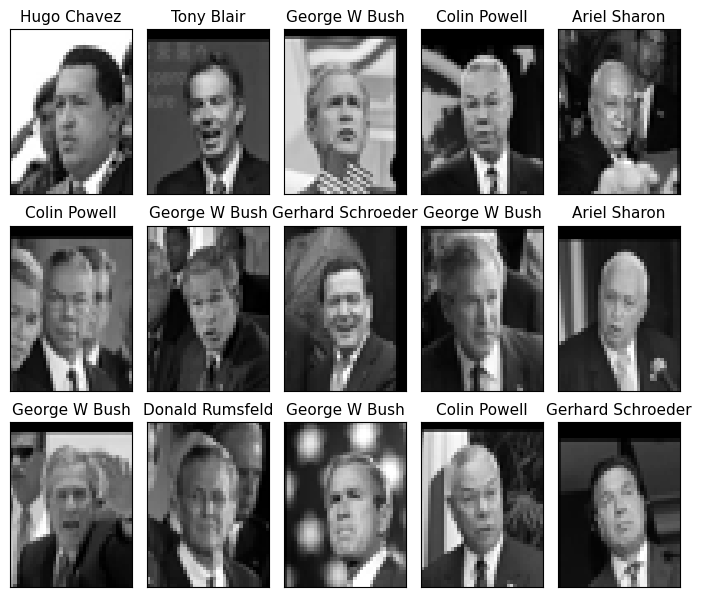

In [6]:
# Hadi bazı yüzleri görelim.
fig = plt.figure(figsize=(7,10))

for i in range(15):
    plt.subplot(5, 5, i + 1)
    plt.title(faces.target_names[faces.target[i]], size=11)
    plt.imshow(faces.images[i], cmap=plt.cm.gray)
    plt.xticks(())
    plt.yticks(())

plt.tight_layout()

**Uyarı (Disclaimer)**: Bu veri setinin hiç çeşitlilik içermediğinin farkındayız ve bunun için şimdiden özür dileriz. Ancak, PCA’yı anlamak için oldukça uygundur (düşük piksel sayısı, siyah-beyaz görüntüler, az sayıda kategori, yüzlerin görüntülerde iyi ortalanmış olması vb.). Bu nedenle, “principal component” kavramını anlamak için lütfen bu challenge’da ilerlemeye devam edin!

## 2) PCA ile sıkıştırma (Compression with PCA)

**1288** gözlemimiz (görüntü) ve **1850** feature’ımız (50 × 37 piksel) var.

Bu kadar az gözlem için bu kadar çok feature’a sahip olmak Makine Öğrenmesi açısından ideal değildir; genel bir kural olarak şu koşulun sağlanması istenir:  
$n_{features} << \sqrt{n_{observations}}$.

**PCA**, verideki bilginin büyük bir kısmını koruyarak feature sayısını daha yönetilebilir bir boyuta indirmeye yardımcı olabilir.

❓ **Düzleştirilmiş (flattened) görüntüleriniz** üzerinde bir `PCA` fit edin ve boyutları **150 bileşene** düşürün  
👉 Fit edilmiş `PCA`’yı **pca** adlı bir değişkende saklayın  
👉 Ardından dönüşüm sonucunu **data_projected** değişkenine atayın

In [7]:
from sklearn.decomposition import PCA

# X: flattened yüz verisi (1288, 1850)
X = faces.data

# 1850 -> 150 boyuta sıkıştıracağız
pca = PCA(n_components=150, random_state=42)

# PCA'yı öğren (ana yönleri bul) ve veriyi o eksenlere projekte et
data_projected = pca.fit_transform(X)

# Kontrol: artık her yüz 150 sayı ile temsil ediliyor olmalı
print("Original X shape:", X.shape)                 # (1288, 1850)
print("Projected (compressed) shape:", data_projected.shape)  # (1288, 150)

Original X shape: (1288, 1850)
Projected (compressed) shape: (1288, 150)


Görüntüler yalnızca ilk **150 principal component** üzerine projekte edildi.

Burada “component” dediğimiz şey, verinin **maksimum varyansa sahip yönleri**dir.

Artık her bir görüntüyü tanımlamak için **1850 piksele** ihtiyacımız yok; sadece **150 değer** yeterli 🤓  

Bu da yaklaşık olarak  $\frac{1850}{150} = 12$  katlık bir kazanç anlamına geliyor 🚀  

❓ Component’larınızın **shape**’ine bakın ve bunun neyi temsil ettiğini anladığınızdan emin olun  
❓ İlk component’ın **shape**’ine bakın ve bunun neyi temsil ettiğini tekrar düşünün


In [8]:
# PCA'nın bulduğu ana bileşenler (yönler)
print("pca.components_ shape:", pca.components_.shape)

# İlk ana bileşen (1 tane yön)
print("First component shape:", pca.components_[0].shape)

pca.components_ shape: (150, 1850)
First component shape: (1850,)


İlk bileşeniniz 1850 değerden oluşan bir vektördür.  
Şimdi her biri 1850 değerden oluşan 150 bileşenimiz var.

Bir yüz, bu bileşenlerin doğrusal bir kombinasyonu olarak tanımlanır.

Nasıl çalıştığını görmek için, indirgenmiş temsilinden bir görüntüyü yeniden oluşturalım.

❓ Sıkıştırılmış görüntülerinizi yeniden oluşturmak için **data_projected** üzerinde `inverse_transform` kullanın  
👉 Sonucu **data_reconstructed** içinde saklayın

In [9]:
# 150 boyuttan tekrar 1850 boyuta geri dön (yaklaşık geri oluşturma)
data_reconstructed = pca.inverse_transform(data_projected)

print("Reconstructed shape:", data_reconstructed.shape)  # (1288, 1850)


Reconstructed shape: (1288, 1850)


❓ Yeniden oluşturulmuş (reconstructed) veri setindeki **13. resmi** (George W. Bush) çizin ve **orijinaliyle karşılaştırın**.

<details>
    <summary>💡 İpucu</summary>
Düzleştirilmiş (flattened) veriyi **50 x 37 piksel** boyutlarında bir görüntüye yeniden şekillendirin (reshape).
</details>

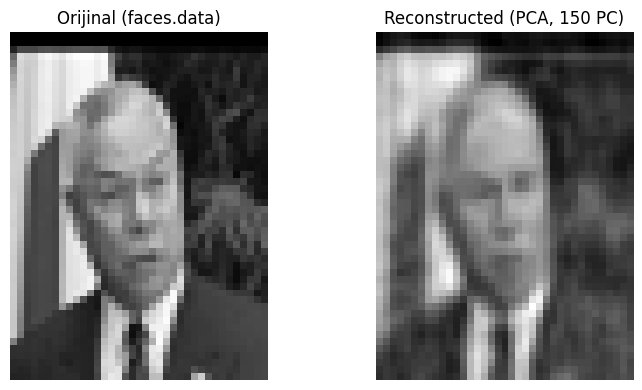

In [13]:
# 13. resmi seçiyoruz (notebook "13. resim" dediği için index=13 kullanıyoruz)
idx = 13

# Orijinal (flattened) yüz -> 50x37'ye geri şekillendir
img_original = faces.data[idx].reshape(50, 37)

# PCA ile reconstructed yüz -> 50x37'ye geri şekillendir
img_reconstructed = data_reconstructed[idx].reshape(50, 37)

# Yan yana görselleştirelim
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.title("Orijinal (faces.data)")
plt.imshow(img_original, cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Reconstructed (PCA, 150 PC)")
plt.imshow(img_reconstructed, cmap="gray")
plt.axis("off")

plt.tight_layout()
plt.show()
# SENİN KODUN BURAYA

❓ Yeniden oluşturulmuş görüntülerin bir seçkisini görmek için aşağıdaki hücreyi çalıştırın.

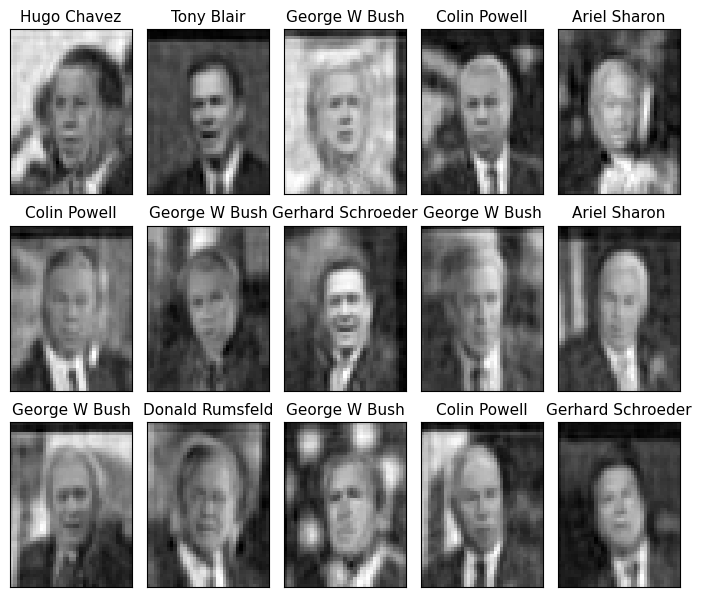

In [11]:
fig = plt.figure(figsize=(7, 10))

for i in range(15):
    plt.subplot(5, 5, i + 1)

    # Her bir görüntüyü, veri kümesinden aldığımız başlıkla birlikte görüntüleyin.
    plt.title(faces.target_names[faces.target[i]], size=11)
    plt.imshow(pca.inverse_transform(data_projected)[i].reshape((50,37)), cmap=plt.cm.gray)

   # Grafik işaretlerini kaldır
    plt.xticks(())
    plt.yticks(())
    
plt.tight_layout()

### 🧪 Kodunu Test Et

In [12]:
from nbresult import ChallengeResult

result = ChallengeResult('projection', shape=data_projected.shape)
result.write()
print(result.check())


============================= test session starts ==============================
platform linux -- Python 3.12.9, pytest-8.3.4, pluggy-1.5.0 -- /home/tumay/.pyenv/versions/workintech/bin/python
cachedir: .pytest_cache
rootdir: /home/tumay/code/S17D3-S-data-face-recoginition/tests
plugins: anyio-4.8.0, dash-3.3.0, typeguard-4.4.2
collecting ... collected 1 item

test_projection.py::TestProjection::test_shape PASSED                    [100%]

============================== 1 passed in 0.28s ===============================


💯 You can commit your code:

git add tests/projection.pickle

git commit -m 'Completed projection step'

git push origin master



## 3) Ana Bileşenlerinizi Araştırın

❓ Tüm veri setinin *“ortalama (mean)”* yüzüne karşılık gelen bir görüntü çizin  
👉 Bu bölümde grafikleriniz için `gray` renk haritasını kullanın

<details>
    <summary>💡 İpucu</summary>
    
`pca.mean_` veya `faces.data.mean(axis=0)` kullanabilirsiniz  
Ayrıca, görüntü olarak çizebilmek için biraz **reshape** işlemi yapmanız gerekecek
</details>

❓ Plot the images corresponding to the **first 5** principal components  

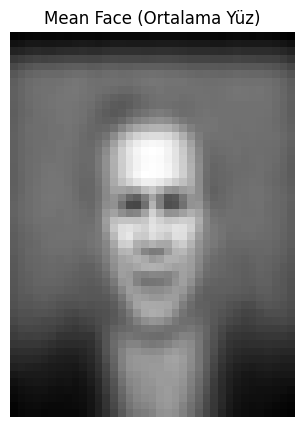

In [14]:
# Ortalama yüz (mean face)
mean_face = faces.data.mean(axis=0)

# Görüntüye geri döndür (50x37)
mean_face_img = mean_face.reshape(50, 37)

plt.figure(figsize=(4, 5))
plt.title("Mean Face (Ortalama Yüz)")
plt.imshow(mean_face_img, cmap="gray")
plt.axis("off")
plt.show()


☝️ Her bir PC, 1850 pikselden oluşan düzleştirilmiş bir “görüntü”dür.  
Biz sadece bunları normal görüntüler olarak görselleştirebilmek için yeniden şekillendirdik.

👇 Aşağıda bu Principal Component’lara ait tanımlar yer almaktadır  

❓ **Lütfen dikkatlice okuyun ve anladığınızdan emin olun**, aksi halde bir ticket 🎟️ açmayı düşünebilirsiniz  

💡 İlk PC’leriniz, 1850 feature’a sahip gözlemlerinizdeki **en önemli _yönlerdir_**

💡 Bunlar, 1850 pikselinizin en önemli **_doğrusal kombinasyonlarıdır_**

💡 Görüntü veri setiniz bu yönler üzerine projekte edildiğinde **en fazla _varyansı_ koruyan** bileşenlerdir  

💡 İlk birkaç PC, 1288 görüntünüz arasında **en fazla _değişkenlik_ içeren 2D piksel ızgarası bölgelerini** temsil eder

❓ **Son 5** ana bileşene karşılık gelen görüntüleri çiziniz.  

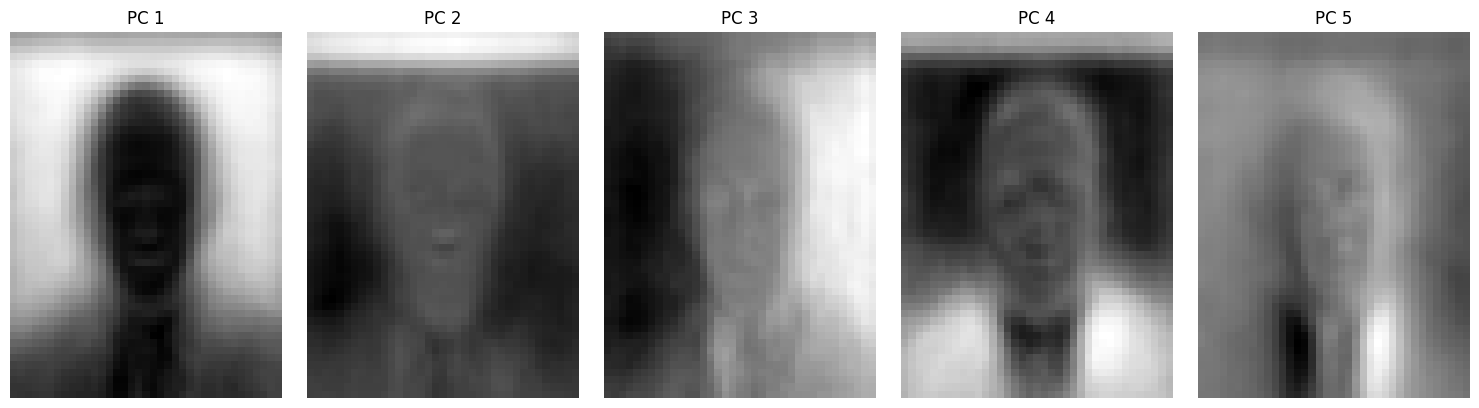

In [15]:
fig, axes = plt.subplots(1, 5, figsize=(15, 4))

for i in range(5):
    ax = axes[i]
    ax.imshow(pca.components_[i].reshape(50, 37), cmap="gray")
    ax.set_title(f"PC {i+1}")
    ax.axis("off")

plt.tight_layout()
plt.show()


Açık alanlar → bu bölgede pozitif değişim
Koyu alanlar → bu bölgede negatif değişim
Kontrast yüksek → o bölge ayırt edici

❓ Aşağıdaki hücreyi çalıştırarak ana bileşenlere karşılık gelen birkaç görüntüyü çizdirin.

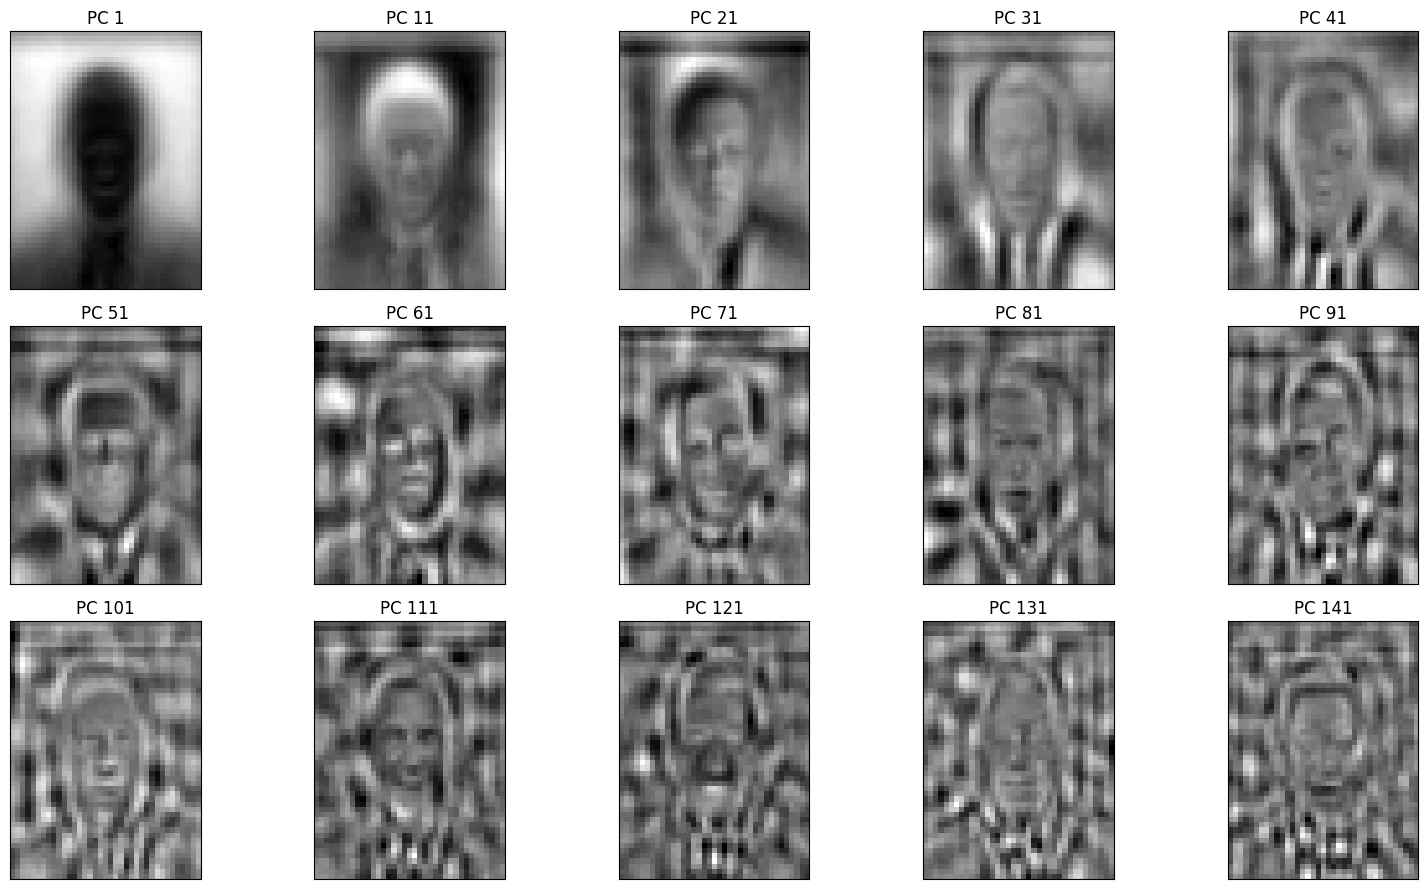

In [16]:
n_rows, n_cols = 3, 5
fig, axs = plt.subplots(n_rows, n_cols, figsize=(16, 9))

for i in range(n_rows * n_cols):
    ax = axs[i // n_cols, i % n_cols]
    ax.set_title(f'PC {i * 10 + 1}', size=12)
    ax.set_xticks(()), ax.set_yticks(())
    ax.imshow(pca.components_[i * 10].reshape(50, 37), cmap='gray')

plt.tight_layout()

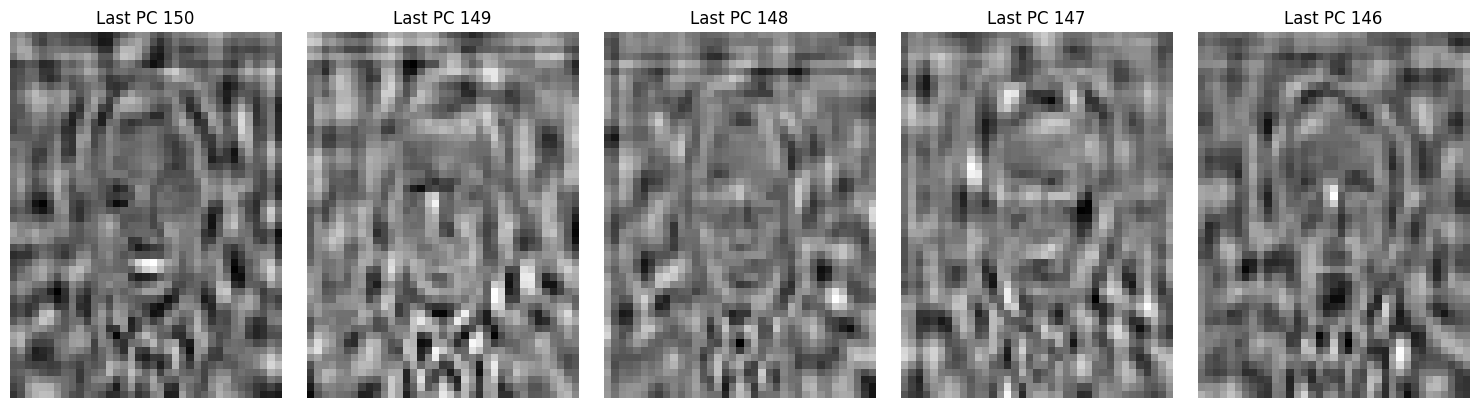

In [17]:
fig, axes = plt.subplots(1, 5, figsize=(15, 4))

for i in range(5):
    idx = - (i + 1)
    axes[i].imshow(pca.components_[idx].reshape(50, 37), cmap="gray")
    axes[i].set_title(f"Last PC {pca.components_.shape[0] - i}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()


☝️ PC’lere bakmak ve neyi temsil ettiklerine dair sezginizi güçlendirmek için biraz zaman ayırın  

İlk PC’lerin, görüntüler arasındaki farkın çoğunu açıklayan en büyük/en basit pattern’ları yakaladığını fark edin:
- Yüzün yönelimi: sola, sağa, yukarı ya da aşağı bakma
- Yüzün, ağzın, burnun ve gözlerin boyutu

Son PC’ler ise en küçük/en detaylı pattern’ları yakalar:
- Ağzın şekli (hareketli ya da hareketsiz)
- Çenenin yapısı

Her görüntü, “mean face” artı 150 adet “PC face”in doğrusal bir kombinasyonu ile temsil edilebilir.

Daha ileri gitmek isterseniz, opsiyonel **Reconstruction of an Original Image** bölümüne göz atın.

PCA’nın ana bileşenleri, yüz görüntülerinde en fazla değişkenliği taşıyan ortak desenleri temsil eder; ilk bileşenler anlamlı yüz yapıları içerirken, son bileşenler çoğunlukla gürültüye yakındır.

## 4) Optimum Bileşen Sayısını Seçin

Makine Öğrenmesi’nde sıkça karşılaştığımız bir **denge (trade-off)** ile karşı karşıyayız ⚖️

**Çok sayıda bileşen (component)** kullanmak, şu özelliklere sahip sıkıştırılmış bir görüntü verir:  
🙂 Görüntü kalitesi açısından orijinaline çok yakın  
🙁 Orijinal görüntüye kıyasla çok da hafif sayılmaz  

**Az sayıda bileşen** kullanmak ise şu özelliklere sahip bir sıkıştırılmış görüntü verir:  
🙂 Orijinal görüntüye kıyasla belirgin şekilde daha hafif  
🙁 Görüntü kalitesi açısından orijinalinden oldukça uzak  

Veriyi çok fazla bilgi kaybetmeden tanımlamak için **kaç bileşene ihtiyaç duyduğumuzu** bulmak son derece önemlidir  

Bunu görsel olarak, **bileşen sayısına karşı açıklanan varyans oranının (explained variance ratio) kümülatif toplamını** çizerek belirleyebiliriz  

Bu bilgi, `sklearn`’den fit edilmiş bir `PCA` nesnesinin  
`explained_variance_ratio_` özelliğinde saklanır  

❓ **Bileşen sayısına karşı, açıklanan varyans oranının kümülatif toplamını** gösteren bir grafik çizin

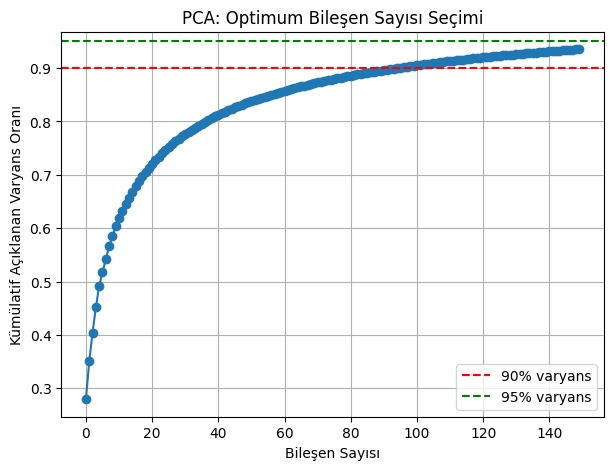

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Kümülatif açıklanan varyans
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(7, 5))
plt.plot(cumulative_variance, marker='o')
plt.axhline(y=0.9, color='r', linestyle='--', label='90% varyans')
plt.axhline(y=0.95, color='g', linestyle='--', label='95% varyans')

plt.xlabel("Bileşen Sayısı")
plt.ylabel("Kümülatif Açıklanan Varyans Oranı")
plt.title("PCA: Optimum Bileşen Sayısı Seçimi")
plt.legend()
plt.grid(True)
plt.show()


PCA’da optimum bileşen sayısı, açıklanan varyansın kümülatif oranının doygunluğa ulaştığı noktadan seçilir; bu nokta bilgi kaybı ile model karmaşıklığı arasındaki en iyi dengeyi temsil eder.

☝️ Bu eğri, toplam varyansın ne kadarının ilk bileşenlerde yer aldığını nicel olarak gösterir.  

❓ Aşağıdaki hücreyi çalıştırın ve grafiği inceleyerek aşağıdaki ifadeleri doğrulayın:  
- **İlk bileşen** tek başına **varyansın yaklaşık %20'sini** açıklamaya yeterlidir.
- İlk **25 bileşen**, **varyansın %75'ini** açıklamak için yeterlidir.
- **Varyansın %90'ını** açıklamak için yaklaşık **94 bileşen** gerekir.

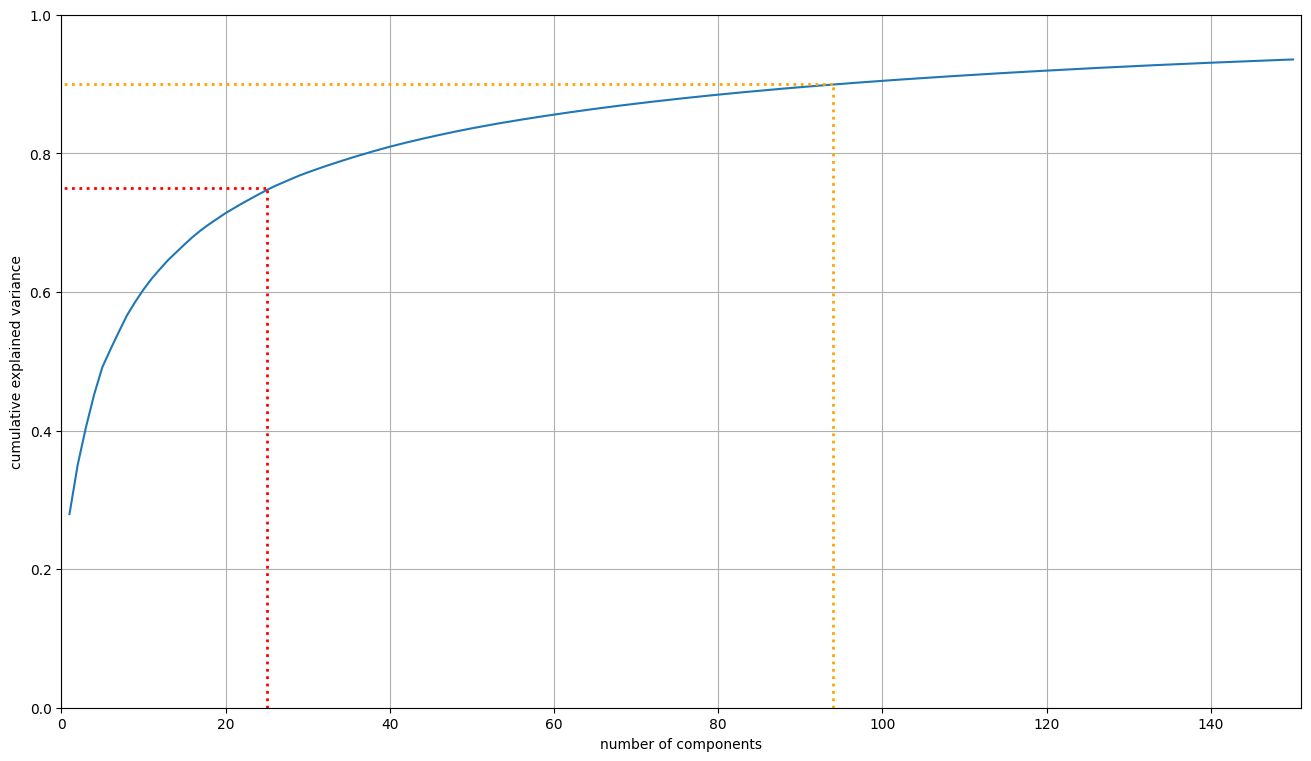

In [19]:
plt.figure(figsize=(16, 9))

# Verileri grafik olarak göster
plt.plot(range(1, pca.n_components_+1), np.cumsum(pca.explained_variance_ratio_))

# Set labels
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

# Etiketleri ayarla
plt.grid()

# Eksenler için sınırları ayarlayın
plt.xlim((0, 151))
plt.ylim((0, 1))

# Grafiğe çizgiler ekle
plt.hlines(
    y=[.75, .9],
    xmin=[-5, -5],
    xmax=[25, 94],
    linestyles='dotted',
    colors=['red', 'orange'],
    linewidth=2
)
plt.vlines(
    x=[25, 94],
    ymin=[0, 0],
    ymax=[.75, .9],
    linestyles='dotted',
    colors=['red', 'orange'],
    linewidth=2
);

❓ Varyansın en az %80'ini elde etmek için tutmanız gereken en küçük bileşen sayısı nedir?  
👉  Cevabınızı `minimal_pc_count` adlı bir değişkene atayın.

In [20]:
import numpy as np

# Her bileşenin açıkladığı varyans oranlarının kümülatif toplamı
cum_var = np.cumsum(pca.explained_variance_ratio_)

# %80'i ilk geçtiği yerin index'i (0-based) -> bileşen sayısı için +1
minimal_pc_count = np.argmax(cum_var >= 0.80) + 1


### 🧪 Kodunu Test Et

In [21]:
from nbresult import ChallengeResult

result = ChallengeResult('components', min_pc = minimal_pc_count)
result.write()
print(result.check())


============================= test session starts ==============================
platform linux -- Python 3.12.9, pytest-8.3.4, pluggy-1.5.0 -- /home/tumay/.pyenv/versions/workintech/bin/python
cachedir: .pytest_cache
rootdir: /home/tumay/code/S17D3-S-data-face-recoginition/tests
plugins: anyio-4.8.0, dash-3.3.0, typeguard-4.4.2
collecting ... collected 1 item

test_components.py::TestComponents::test_minimal_pc PASSED               [100%]

============================== 1 passed in 2.65s ===============================


💯 You can commit your code:

git add tests/components.pickle

git commit -m 'Completed components step'

git push origin master



## 5) Görüntüleri Sınıflandırma (Özellik Mühendisliği Olarak PCA)

Artık **PCA**’yı **denetimli (supervised) Makine Öğrenmesi** için kullanma zamanı 🚀

İşte görevin 👇

Ünlü kişilerden oluşan bir küme içinden verilen bir **yüz fotoğrafına bakarak**, modelin bu yüzün **kime ait olduğunu** söyleyebilmesi gerekiyor.

Bu görevi Makine Öğrenmesi terimlerine çevirirsek 👇
- **Örnekler (samples)**: Görüntüler (resimler)
- **Özellikler (features)**: Görüntülerin pikselleri
- **Hedef (target)**: Birden fazla sınıf arasından biri (7 sınıf)

❓ Sınıflandırma görevine uygun, seçtiğiniz bir modeli cross-validate edin
👉 Modeli eğitmek ve değerlendirmek için gereken süreyi kaydedin

<details span='markdown'>
    <summary>💡İpucu </summary>
Çalışma süresini kaydetmek için aşağıdaki yöntemi kullanabilirsiniz:    
```python
from time import time
start = time()
# Çalışma süresini ölçmek istediğiniz KOD
execution_time = time() - start
```
</details>

In [23]:
X = faces.data
y = faces.target

❓ Aynı adımları izleyin, bu sefer görüntülerinizi özellik olarak kullanın. 

In [24]:
start = time()
cvs = cross_validate(SVC(class_weight="balanced"), X, y, cv=5, scoring='accuracy')
duration = time() - start 

score_original = cvs['test_score'].mean()
time_original = duration

round(score_original, 3), round(time_original, 3)

(np.float64(0.575), 3.314)

In [25]:
start = time()
cvs = cross_validate(SVC(class_weight="balanced"), data_projected, y, cv=5, scoring='accuracy')
duration = time() - start 

score_reduced = cvs['test_score'].mean()
time_reduced = duration

round(score_reduced, 3), round(time_reduced, 3)

(np.float64(0.568), 0.482)

👉 Skorlarınızı ve çalışma sürelerini karşılaştırın

Modelinizin kalitesi bir miktar düşmüş olmalı.
Ancak modeli “seçmek” (eğitmek ve değerlendirmek) için gereken süre büyük ölçüde azalmış olmalı!

İş dünyası açısından bakıldığında bu büyük bir başarıdır 🏆
ML Ops modülünde de göreceğiniz gibi, modelleri eğitmenin bir maliyeti vardır 💸🙈

## 6) Optimum Bileşen Sayısını Arayın

*Bu sefer, Makine Öğrenimi yöntemi: Izgara Arama*.

💡 Artık denetimli (özellik-hedef) ML ayarımız olduğuna göre, en uygun bileşen sayısını ızgara araması ile bulabiliriz.

❓ Devam etmeden önce, verilerinizin %30'unu test seti olarak ayırın  

👉 Her zamanki gibi, bölünmüş verilerinizi `X_train`, `X_test`, `y_train`, `y_test` olarak atayın  
👉 `train_test_split` içinde, sonuçları arkadaşınızla karşılaştırmak için `random_state=42` kullanın

💡 Modelimizi **eğitim seti** üzerinde **çapraz doğrulama** yaparak **seçeceğiz**  
Ardından modelimizi **test seti** üzerinde **puanlayarak** **değerlendireceğiz**

In [26]:
# from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [27]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.pipeline import make_pipeline
# from sklearn.svm import SVC

💡 Grid search için bir pipeline gereklidir  

❓ [`make_pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html) kullanarak iki adımdan oluşan bir pipeline oluşturun:
- Bir `PCA` (şimdilik bileşen sayısını seçmenize gerek yok)
- Tahminleyici (estimator) olarak [`SVC`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) algoritması

In [28]:
pipe = make_pipeline(PCA(random_state=42), SVC()) # random_state added for reproducibility purposes
pipe.get_params()                                 # the solver of PCA introduces some randomness

{'memory': None,
 'steps': [('pca', PCA(random_state=42)), ('svc', SVC())],
 'transform_input': None,
 'verbose': False,
 'pca': PCA(random_state=42),
 'svc': SVC(),
 'pca__copy': True,
 'pca__iterated_power': 'auto',
 'pca__n_components': None,
 'pca__n_oversamples': 10,
 'pca__power_iteration_normalizer': 'auto',
 'pca__random_state': 42,
 'pca__svd_solver': 'auto',
 'pca__tol': 0.0,
 'pca__whiten': False,
 'svc__C': 1.0,
 'svc__break_ties': False,
 'svc__cache_size': 200,
 'svc__class_weight': None,
 'svc__coef0': 0.0,
 'svc__decision_function_shape': 'ovr',
 'svc__degree': 3,
 'svc__gamma': 'scale',
 'svc__kernel': 'rbf',
 'svc__max_iter': -1,
 'svc__probability': False,
 'svc__random_state': None,
 'svc__shrinking': True,
 'svc__tol': 0.001,
 'svc__verbose': False}

❓ Pipeline’ınızı kullanan çapraz doğrulamalı (cross-validated) bir grid search oluşturun  

👉 `PCA` için yalnızca aşağıdaki bileşen sayıları arasında arama yapın:  
`[50, 100, 200, 300]`

In [29]:
param_grid = {"pca__n_components": [50, 100, 200, 300]}

clf = GridSearchCV(
    pipe,
    param_grid,
    cv=5,
    n_jobs=-1,
    scoring='accuracy'
)

❓ En iyi modelinizin [classification report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html#sklearn.metrics.classification_report) çıktısını yazdırın  
👉 Grid search sonucunda elde ettiğiniz **best estimator**’ı kullanarak **X_test** için tahminler üretin  
👉 Bu tahminleri **y_test** ile karşılaştırarak classification report’u yazdırın

In [33]:
from sklearn.metrics import classification_report

clf.fit(X_train, y_train)  # mutlaka çalışmış olmalı

y_pred = clf.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.70      0.30      0.42        23
           1       0.65      0.46      0.54        71
           2       0.00      0.00      0.00        37
           3       0.48      0.96      0.64       159
           4       1.00      0.06      0.11        33
           5       0.00      0.00      0.00        21
           6       0.50      0.07      0.12        43

    accuracy                           0.51       387
   macro avg       0.48      0.27      0.26       387
weighted avg       0.50      0.51      0.41       387



/home/tumay/.pyenv/versions/workintech/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/tumay/.pyenv/versions/workintech/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/tumay/.pyenv/versions/workintech/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier,

Sınıflarından biri için doğru tahminler yoksa, UndefinedMetricWarning uyarısı alabilirsiniz.

❓ En iyi puanı veren bileşen sayısı kaçtır?  
👉 Değeri **best_n_components** adlı bir değişkene atayın.

In [34]:
best_n_components = clf.best_estimator_.get_params()['pca__n_components']
best_n_components

200

### 🧪 Kodunu Test Et

In [35]:
from nbresult import ChallengeResult

result = ChallengeResult('search_components', best_pc=best_n_components)
result.write()
print(result.check())


============================= test session starts ==============================
platform linux -- Python 3.12.9, pytest-8.3.4, pluggy-1.5.0 -- /home/tumay/.pyenv/versions/workintech/bin/python
cachedir: .pytest_cache
rootdir: /home/tumay/code/S17D3-S-data-face-recoginition/tests
plugins: anyio-4.8.0, dash-3.3.0, typeguard-4.4.2
collecting ... collected 1 item

test_search_components.py::TestSearchComponents::test_best_pc_number PASSED [100%]

============================== 1 passed in 2.58s ===============================


💯 You can commit your code:

git add tests/search_components.pickle

git commit -m 'Completed search_components step'

git push origin master



## 7) Ölçeklendirme, dengeleme ve ayarlama ne durumda?

*Tam makine öğrenimi süreci*

PCA üzerinde uzun uzun durduk ancak skorunuzu artırmak için kullanabileceğiniz **3 ML yöntemi** daha var:
- PCA uygulamadan önce verinizi ölçeklendirmek
- Sınıflar dengeli olmadığı için bir dengeleme yöntemi kullanmak
- Tahminleyiciniz için en uygun hiperparametreleri grid search ile bulmak

Haydi bunları uygulayalım ve `PCA`’yi şimdiye kadar gördüğümüz ML teknikleriyle birlikte kullanmanın daha yüksek bir skor elde etmemize nasıl yardımcı olduğunu görelim.

❓ Yalnızca PCA + SVC ile elde etti

In [36]:
baseline = pd.Series(y).value_counts(normalize=True).max()

score_base = cross_validate(
    make_pipeline(
        PCA(n_components=best_n_components),
        SVC()
    ),
    X, y,
    scoring='accuracy',
    cv=3,
    n_jobs=-1
)['test_score'].mean()


print(f"""
    Accuracy scores:
    Baseline (frequency of most frequent class): {baseline: .2%}
    Base Model (PCA + SVC): {score_base:.2%}
""")


    Accuracy scores:
    Baseline (frequency of most frequent class):  41.15%
    Base Model (PCA + SVC): 52.02%



###  Ölçeklendirme (Scaling)

❓ Verinizi `PCA` ile boyut indirgemeden önce ölçeklendirin  
👉 Aşağıdaki **3 adımdan** oluşan bir pipeline oluşturun:
- `StandardScaler` ile ölçeklendirme
- `PCA` ile boyut indirgeme (önceki aramanızdan elde ettiğiniz **best_n_components** değerini kullanın)
- `SVC` ile tahmin (tüm varsayılan parametreleri koruyun)

In [37]:
# from sklearn.preprocessing import StandardScaler
pipe_scaling = make_pipeline(StandardScaler(), PCA(n_components=best_n_components), SVC())

❓ Pipeline’ınızı tüm **X** ve **y** üzerinde **3 katlı (3-fold)** cross-validation ile değerlendirin  
👉 Ortalama skoru **score_scaling** değişkenine kaydedin  
👉 Yeni skorunuzu kontrol edin

In [38]:
score_scaling = cross_validate(
    pipe_scaling,
    X, y,
    scoring='accuracy',
    cv=3,
    n_jobs=-1
)['test_score'].mean()

round(score_scaling, 3)

np.float64(0.628)

☝️ Yukarı çıkıyoruz

### Dengelemek

❓ Hedef sınıflarınızın yayılmasını kontrol edin

In [39]:
pd.Series(y).value_counts(normalize=True)

3    0.411491
1    0.183230
6    0.111801
2    0.093944
4    0.084627
0    0.059783
5    0.055124
Name: proportion, dtype: float64

☝️ Gördüğünüz gibi sınıflar ciddi şekilde **dengesiz**

En çok temsil edilen sınıf görüntülerin %41’inde yer alıyor  
En az temsil edilen sınıf ise yalnızca %5,5 oranında görünüyor  

Bu durum, modelinizin en çok temsil edilen sınıfı gereğinden fazla tahmin etmesine neden olur ve şu sonuçları doğurur:
- En çok temsil edilen sınıflar için **precision (kesinlik)** skorunun düşmesi  
- En az temsil edilen sınıflar için **recall (duyarlılık)** skorunun düşmesi

❓ Sınıf dengesizliğini dikkate alan başka bir pipeline eğitin  
👉 `SVC` tahmin edicisinin [dokümantasyonunu](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) inceleyin  
👉 `SVC` içinde sınıf dengesizliğine yardımcı olan parametreyi bulun ve kullanın  
👉 Ortalama skoru **score_balanced** değişkenine kaydedin ve yeni skorunuzu kontrol edin

In [40]:
pipe_balanced = make_pipeline(
    StandardScaler(),
    PCA(n_components=best_n_components),
    SVC(class_weight='balanced')
)

🚀 Sınır yok

### İnce Ayar

❓ En yüksek skoru veren hiperparametre kombinasyonunu bulmak için modelinizi ince ayar yapın  
👉 En fazla 3 hiperparametre üzerinde arama yapın  
👉 Her biri için en fazla 3 değer deneyin  
👉 Aşağıda kullanabileceğiniz örnek bir arama sözlüğü verilmiştir:
```python
grid = {
        'svc__kernel': ['rbf', 'poly', 'sigmoid'],
        'svc__gamma': [1e-4, 1e-3, 1e-2],
        'svc__C': [10, 1e2, 1e3]
}
```
ℹ️ Bu hiperparametre aralıkları sadece örnek amaçlıdır ve en iyi model kombinasyonunu garanti etmez. Değerleri dilediğiniz gibi değiştirebilirsiniz!

In [41]:
grid = {
    'svc__kernel': ['rbf', 'poly', 'sigmoid'],
    'svc__gamma': [1e-4, 1e-3, 1e-2],
    'svc__C': [10, 1e2, 1e3]
}

search = GridSearchCV(
    pipe_balanced, 
    grid,
    cv=3,
    scoring='accuracy'
)

search.fit(X, y)
score_tuned = search.best_score_
round(score_tuned, 5)

np.float64(0.7593)

In [43]:
pipe_balanced._final_estimator.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': 'balanced',
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [44]:
grid = {
    'svc__kernel': ['rbf', 'poly', 'sigmoid'],
    'svc__gamma': [1e-4, 1e-3, 1e-2],
    'svc__C': [10, 1e2, 1e3]
}

search = GridSearchCV(
    pipe_balanced, 
    grid,
    cv=3,
    scoring='accuracy'
)

search.fit(X, y)
score_tuned = search.best_score_
round(score_tuned, 5)

np.float64(0.75929)

🚀 Temel modelimize kıyasla doğruluğu 10 puan artırdık  

`PCA` gibi bir boyut indirgeme tekniği sayesinde modellerimizi daha hızlı eğitebilir, çapraz doğrulayabilir ve ince ayar yapabiliriz  

İnce ayar süreci son derece uzun olabilir; bu süreci veriye önceden boyut indirgeme uygulayarak hızlandırabilmek büyük bir avantajdır

### 🧪 Kodunu Test Et

In [45]:
from nbresult import ChallengeResult

result = ChallengeResult(
    'full_pipeline',
    score_scaled=score_scaling,
    score_balanced=score_balanced,
    score_tuned=score_tuned
)

result.write()
print(result.check())

NameError: name 'score_balanced' is not defined

🏁 **Not defterini itmeyi unutma.**  

Günün görevlerini yerine getir ve zamanın olursa buraya geri dön 😉

<details>
  <summary markdown=‘span’>🍔 Düşünülmesi gerekenler</summary>

PCA ön işleme tabi tutulmuş sınıflandırma sonucunu, ön işleme tabi tutulmamış sonuçla karşılaştırarak şunları kontrol edebilirsiniz:
1. Daha hızlı mı?
2. Daha mı iyi?
3. Doğrusal ayrımı bulmaya yardımcı oluyor mu?
</details>

## 8) (İsteğe bağlı) Orijinal görüntünün yeniden oluşturulması

👉 `inverse_transform` kullanmadan görüntüyü adım adım yeniden oluşturan aşağıdaki hücreleri inceleyin.  

👉 Örnek olarak tek bir görüntü seçerek başlıyoruz.

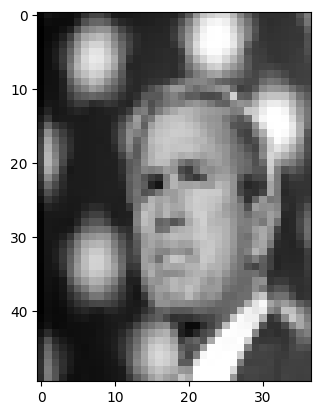

In [46]:
# 13. görüntüyü yeniden oluşturalım
image_original = faces.images[12];
image_compressed = data_projected[12];

plt.imshow(image_original, cmap='gray');

👉 Çarpımların toplamını manuel olarak yapıyoruz:  $X\_reconstructed_{i} = \sum_{i=1}^{n\_components}{X_{projected_i} * W_i}$  
$W_i$   `i. temel bileşeni (principal component) ifade eder`  

In [47]:
# Tüm görüntülerin ortalamasından yeniden yapılandırmaya başlıyoruz.
image_reconstructed = pca.mean_.copy(); 

# Ardından, sıkıştırılmış temsilinin her 150 girdisinin toplamını, karşılık gelen ana bileşenlerle ağırlıklandırarak görüntüyü yeniden oluşturun.
reconstruction = list()

for i in range(pca.n_components_):
    image_reconstructed += pca.components_[i] * image_compressed[i]
    reconstruction.append(image_reconstructed.copy())

👉 Yeniden oluşturulan görüntüyü orijinal görüntünün yanına yerleştiriyoruz.

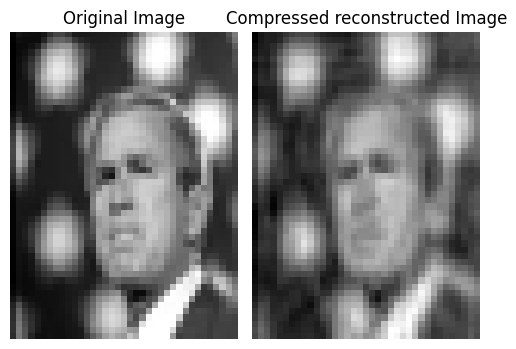

In [48]:
# Orijinal ve sıkıştırılmış görüntüyü çiz.
fig, ax = plt.subplots(1, 2, figsize = (5, 5))

# Orijinal
ax[0].imshow(image_original, cmap='gray')
ax[0].set_title('Original Image')

# Yeniden inşa edildi
ax[1].imshow(image_reconstructed.reshape(faces.images[0].shape), cmap='gray')
ax[1].set_title('Compressed reconstructed Image')

for ax in fig.axes:
    ax.axis('off')

plt.tight_layout()

👉 Görüntüyü yeniden yapılandırmanın farklı aşamalarında çiziyoruz.

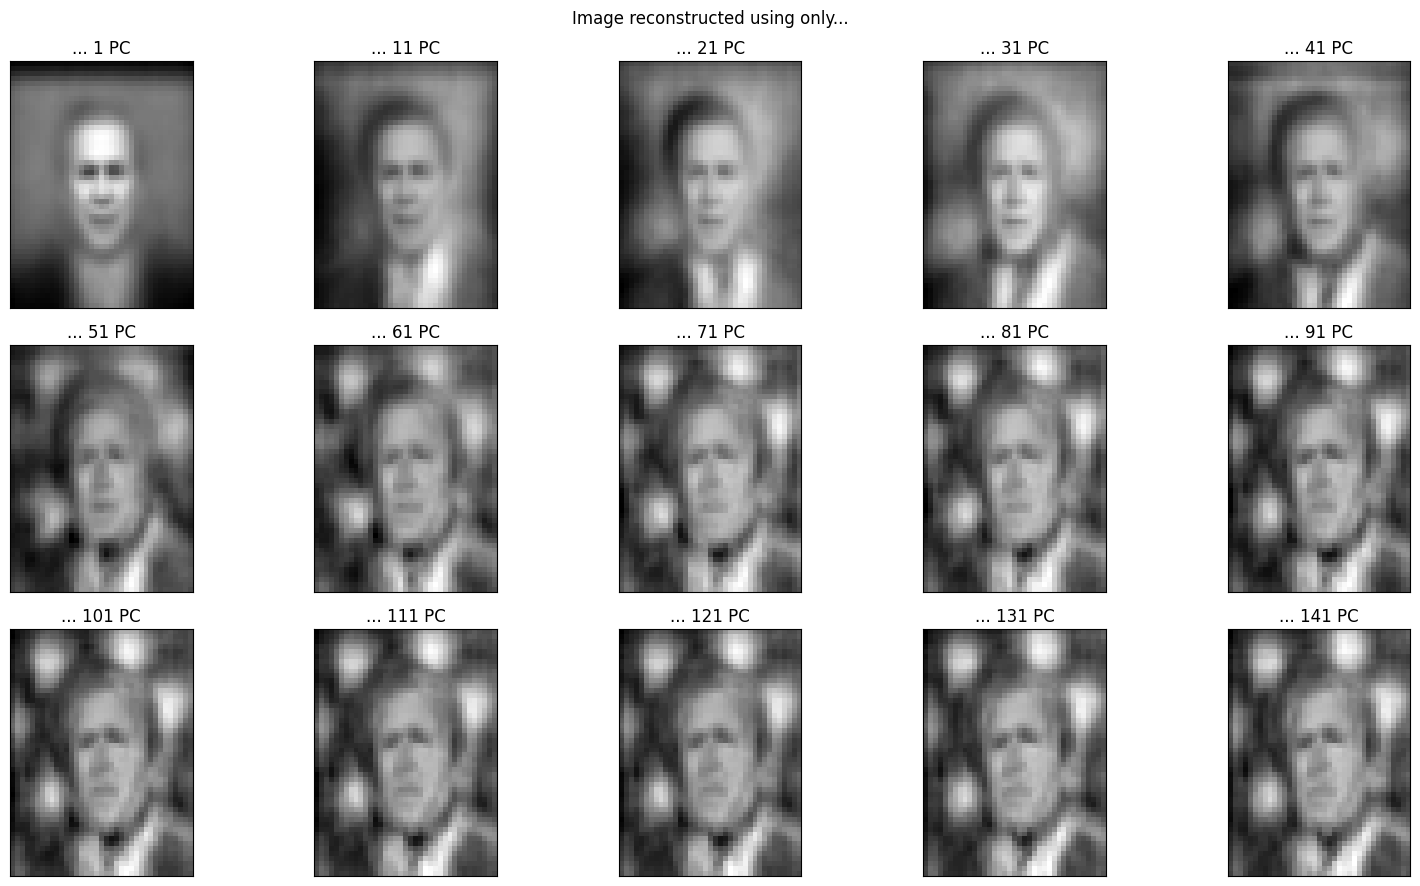

In [49]:
# Yeniden yapılandırmanın farklı aşamalarında birkaç görüntü çizin
n_rows, n_cols = 3, 5
fig, axs = plt.subplots(n_rows, n_cols, figsize=(16, 9))
plt.suptitle('Image reconstructed using only...')

for i in range(n_rows * n_cols):
    ax = axs[i // n_cols, i % n_cols]
    ax.set_title(f'... {i * 10 + 1} PC', size=12)
    ax.set_xticks(()), ax.set_yticks(())
    ax.imshow(reconstruction[i * 10].reshape(50, 37), cmap='gray')

plt.tight_layout()